In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.models as models
from tqdm import tqdm
import csv
import numpy as np
import os

class DrivingDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, delimiter=";")
        
        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((256, 256)),
            T.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ])
        
        # Fix path references if needed
        self.data["Path"] = self.data["Path"].apply(
            lambda x: x.replace("/home/nitesh/Downloads/Linux_Roversim/", "")
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = row['Path']
        steering_angle = row['SteerAngle']
        throttle = row['Throttle']

        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        # find mean and subtract mean
        # mean = img_rgb.mean(axis=(0, 1))
        # img_rgb = img_rgb - mean
        # img_rgb = img_rgb.astype(np.float32)  # ensure float32
        pil_img = T.functional.to_pil_image(img_rgb)

        tensor_img = self.transform(pil_img)
        label = torch.tensor([steering_angle, throttle], dtype=torch.float)

        return tensor_img, label
    

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
dataset = DrivingDataset(csv_file="train_data_3/robot_log.csv")
print(f"Dataset size: {len(dataset)}")
# Split the dataset into training and validation sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)


class ResNetSteeringThrottle(nn.Module):
    def __init__(self, backbone='resnet50', pretrained=True):
        super().__init__()
        
        # 1) Load a pretrained ResNet
        if backbone == 'resnet18':
            self.resnet = models.resnet18(pretrained=pretrained)
            in_features = 512
        elif backbone == 'resnet34':
            self.resnet = models.resnet34(pretrained=pretrained)
            in_features = 512
        elif backbone == 'resnet50':
            self.resnet = models.resnet50(pretrained=pretrained)
            in_features = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # 2) Freeze *all* layers first (no grad for them)
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # OPTIONAL: unfreeze the last residual block (layer4) to allow some fine-tuning
        # Comment out if you truly want to freeze everything
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True
        
        # 3) Replace the final classification layer with Identity (pass-through).
        #    This means ResNet will output a feature vector of size `in_features`.
        self.resnet.fc = nn.Identity()

        self.head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(128, 2)  # [steering, throttle]
        )

    def forward(self, x):
        # Pass through ResNet to get features
        features = self.resnet(x)  # shape: (batch_size, in_features)
        # Pass through our new head
        out = self.head(features)  # shape: (batch_size, 2)
        return out

model = ResNetSteeringThrottle().to(device)


In [ ]:
model.load_state_dict(torch.load("train_data_3_models/model_epoch_100.pth"))

In [ ]:
import matplotlib.pyplot as plt

/home/nitesh/miniconda3/envs/nerfstudio/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


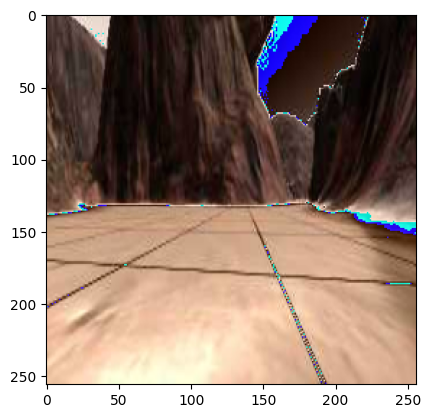

Label: [0. 0.]
Output: [0.03404209 0.116781  ]


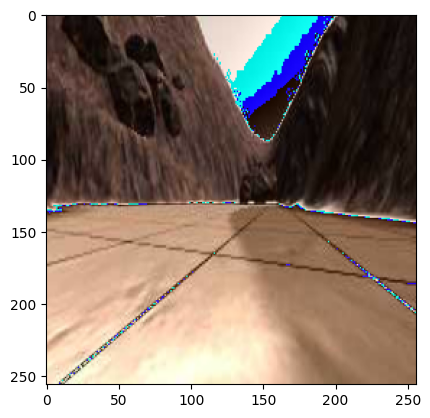

Label: [0. 0.]
Output: [0.00683588 0.3342338 ]


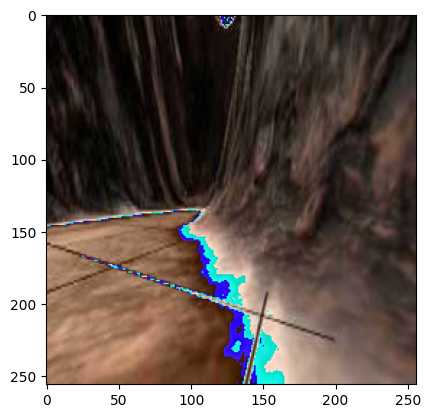

Label: [15.  0.]
Output: [-0.00861377  0.23596445]


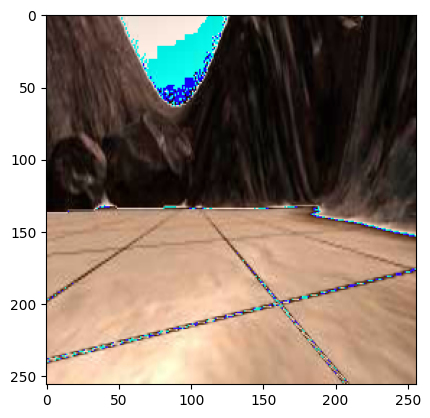

Label: [0. 0.]
Output: [-0.02570566  0.14716609]


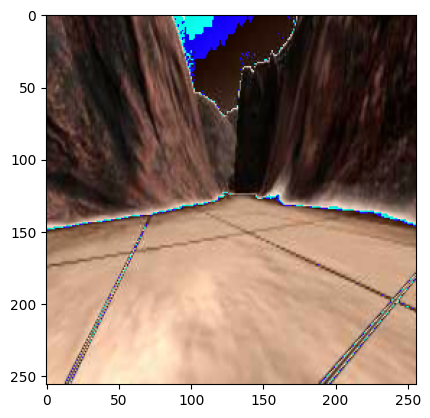

Label: [0. 1.]
Output: [-0.03017834  0.08751366]


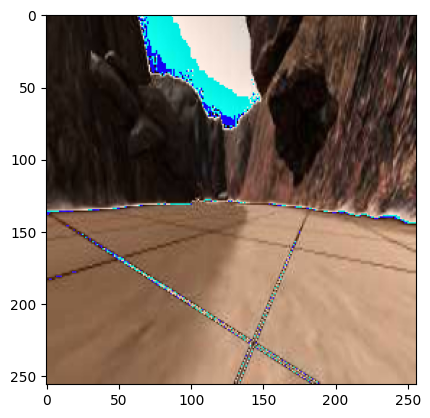

Label: [3.70289 0.     ]
Output: [-0.01940471  0.07030071]


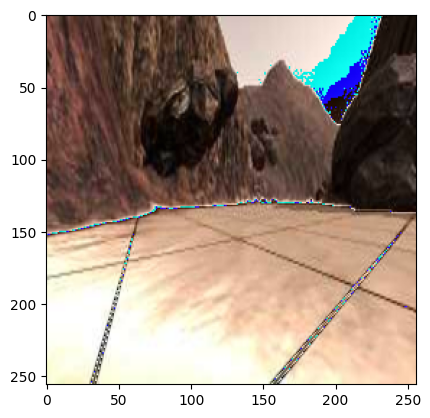

Label: [0. 0.]
Output: [-0.10863796  0.3030243 ]


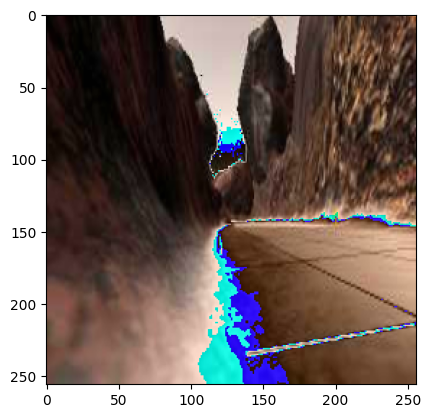

Label: [0. 0.]
Output: [-0.01261172  0.18116862]


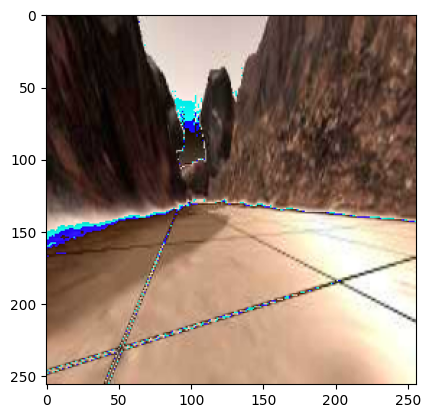

Label: [10.5305  0.    ]
Output: [-0.00967253  0.05331322]


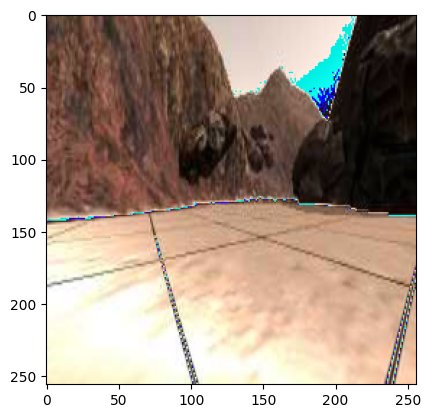

Label: [0. 0.]
Output: [-0.01617029  0.07884495]


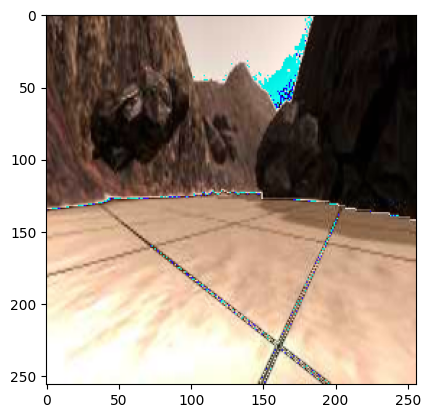

Label: [0. 1.]
Output: [0.04913007 0.2580071 ]


In [28]:
count = 0
for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    outputs = outputs.cpu().detach().numpy()
    # Convert images to uint8
    images = (images * 255).astype(np.uint8)
    # Convert labels to numpy array
    labels = labels.astype(np.float32)
    # Convert outputs to numpy array
    outputs = outputs.astype(np.float32)
    plt.imshow(images[0].transpose(1, 2, 0))
    plt.show()
    print(f"Label: {labels[0]}")
    print(f"Output: {outputs[0]}")
    count += 1
    if count > 10:
        break

In [ ]:
outputs